In [3]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import operator as op
from decimal import *
import pickle
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [4]:
%run ../cow.py

TODO
* Confirm Medium Optimization actually finds best alpha/beta instead of stopping early
* 

Plan:

1. Finish optimizing alpha, beta (downlink, uplink target drops)
2. Add Error Exponent
3. Determine sequence of plots  
        Requires Video Call
    * Waterfall
    * Slice of Waterfall
    * Optimization Curves vs Number of Nodes
4. Draft 1 -- Next Weekend 6/4

In [5]:
# 21 from Hamming Code
# Quantize by 21 (to get all possible RS blocklengths)
# 1400 = min bits for one phase, 4200 = entire protocol
# hs_rs_table(op_SNR, rate, blocklength)
class node_table():
    op_SNR = arange(-2.5, 11, 0.01)
#     padd = 0.1*10**(-9)
    
    # num_nodes = n
    def __init__(self, n, down=True):
        self.num_node = n
        minb = n * 160 * 7 / 4
#         quantize = (20000-minb*2)/100
        bitrange = arange(minb, 3*1400-minb, 21)
        self.bitrange = bitrange
#         rate = num_node * 160 / bitrange * 7 / 4
#         blocklength = bitrange / 21
        num_tables = len(bitrange)
        self.tables = {}
        for b in self.bitrange:
#             b = int(bitrange[bidx])
            block = b/21 if down else b/21/n
            self.tables[b] = hs_rs_table(self.op_SNR, n*160/b, int(block))

In [6]:
# Final

# p_add_1 = 0.1 * 10**(-9)
# p_add_2 = 0.1 * 10**(-9)
# p_add_3 = 0.1 * 10**(-9)

# SNR_down = downtable[0][np.where(np.array(downtable[1])<=p_add_1)[0][0]]
# SNR_up = uptable[0][np.where(np.array(uptable[1])<=p_add_2)[0][0]]
# xorfunc = interp1d(codetable[0], codetable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

def xor_analysis_opt(N, p_add_3, nom_SNR, actual_SNR, p_add_1=10**(-9), p_add_2=10**(-9)):
    hcrit_1 = hcrit_2 = 10**((actual_SNR - nom_SNR)/10) # linear fade
    p_fade_1 = 1 - np.exp(-hcrit_1)
#     hcrit_2 = 10**((actual_SNR - nom_SNR)/10) # linear fade
    p_fade_2 = 1 - np.exp(-hcrit_2)
#     p_fade_1 = p_fade_2 = 1 - np.exp(-1)
    p_link_1 = p_fade_1 + (1 - p_fade_1) * p_add_1
    p_link_2 = p_fade_2 + (1 - p_fade_2) * p_add_2
    q = p_add_1 / p_link_1
#     p_add_3 = xorfunc(SNR)
    
    result = 0
    for ad in range(1, N+1):
        p_ad = nCr(N, ad) * (1 - p_link_1)**ad * p_link_1**(N-ad)
        adn_result = 0
        for adu in range(1, ad+1):
            p_adu = nCr(ad, adu) * (1 - p_add_2)**adu * p_add_2**(ad-adu)
            p_adn_success = (1 - p_add_3)**(ad - adu)
            adn_result += p_adu * p_adn_success
            
        b_result = 0
        for b in range(0, N-ad+1):
            bu_result = 0
            for bu in range(0, b+1):
                p_bu = nCr(b, bu) * (1 - p_add_2)**bu * p_add_2**(b-bu)
                p_bu_success = (1 - p_add_3)**bu
                p_rest_success = ((1 - p_link_2**ad) * (1 - p_add_3)**2)**(N-ad-bu)
                bu_result += p_bu * p_bu_success * p_rest_success
                
            p_b = nCr(N-ad, b) * q**b * (1-q)**(N-ad-b)
            b_result += p_b*bu_result
            
        result += p_ad * adn_result * b_result
#         print 'P(success)', result, 'P(b)', b_result, 'P(adn)', adn_result 
#     print p_add_3, result, b_result
#     if 1-result <= 10**(-9):
#         print p_ad, adn_result, b_result
    return result

Optimized:

Hyperparameter: Downlink Target Drop Probability, Uplink Target Drop Probability  
Big Search: Effective SNR  
Set Effective SNR (SNR experienced at the receiver after the fade):  
*  What is the downlink blocklength such that we achieve Downlink Target Drop at this Effective SNR? --> Down blocklength (lookup in table << only additive noise)  
*   What is the downlink blocklength such that we achieve Downlink Target Drop at this Effective SNR? --> Up blocklength  
*   XOR blocklength --> 4,200 - Down blocklength - Up blocklength
*   Calculate Code Drop Probability for XOR blocklength at Effective SNR --> Additive noise in XOR phase
*   Search Range(Effective SNR, Effective SNR + 90 dB) << this represents SNR at Transmitter
* *       Do calculate of XOR Analysis with XOR_Additive Noise, Fade = f(Effective_SNR - Transmitter_SNR)
Return Transmitter_SNR + other data for funs so Leah can analyse it

2 approximations:
* Loudest Talker
* If fade too large code can't save --> Total Probability Rule
* If fade not too large, it's AT the critical fade (this is worse than reality, it's a worst case scenario)

Max Optimized -- Optimized over alpha (downlink target drop), beta (uplink target drop), rates (downlink blocklength, uplink blocklength) (guarantees XOR <= some target e.g. $10^{-9}$)

Medium Optimized -- Optimized over alpha, beta, **not** optimized over rates (downlink = 1400, uplink = 1400 = total/3) (same guarantee, XOR <= target)

Not Optimized -- Given alpha/beta, given rates, find SNR st XOR <= target  
At $10^{-3}$ Not Optimized should return 11 (max of SNR_range) across the board because infeasible

Really Not Optimized -- Just look for transmitter SNR, set p_add_1 = p_add_2 = p_add_3 = $10^{-10}$


Run plots on Shannon, take slice of waterfall from Shannon to Hamming (or whatever code) at level $10^{-11}$, add the code gap to Vasuki's results and see how they compare to our optimized results--how much worse is the protocol relative to a naive penalty approximation (note that $10^{-11}$ is another approximation but a valid heuristic)
        


In [5]:
def optimization(N, tx_SNR_range, filepath_down, filepath_up, downtarget=10**(-9), uptarget=10**(-9)):
    protocol_target = 10**(-9)
    downFile = filepath_down + str(N) + '.in'
    downNode = load_table(downFile)
    upFile = filepath_up + str(N) + '.in'
    upNode = load_table(upFile)
    
    for nominal_SNR in tx_SNR_range:
        for actual_SNR in arange(max(0, nominal_SNR-90), nominal_SNR, 1):
            downbit, upbit = float("inf"), float("inf")
            for bit in downNode.bitrange:
                bittable = downNode.tables[bit]
                func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
                if func(actual_SNR) <= downtarget:
                    downbit = bit
                    break
            for bit in upNode.bitrange:
                bittable = upNode.tables[bit]
                func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
                if func(actual_SNR) <= uptarget:
                    upbit = bit
                    break
            xorbit = 4200 - downbit - upbit
            if xorbit <= 0: continue
#             xorbit = max(0, 4200 - downbit - upbit)
            # We calculate reeddrop each time because the rate changes every time (new table)
            blocklength = int(xorbit / 21)
            rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
            if rate > 1: continue
            k = (1-rate)*blocklength
            pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
            hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
            hcf = 1 - (1-hcerr)**3
            reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
            xor_opt = xor_analysis_opt(N, reeddrop, nominal_SNR, actual_SNR, downtarget, uptarget)
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nominal_SNR, downbit, upbit, xorbit)
#             if actual_SNR == SNR_range[-1]:
#                 print N, actual_SNR, downbit, upbit, xorbit, reeddrop
#     print N, nominal_SNR, actual_SNR, downbit, upbit, xorbit, reeddrop
#     return (10, 10, 10, 10, 10) # fake data to show answer outside nominal range

In [16]:
filepath_down = '../data_tables/short_block_test/down/n'
filepath_up = '../data_tables/short_block_test/up/n'

In [42]:
%%time
protocol_target = 10**(-9)
# lower precision of SNR_range leads to safe overestimate
tx_SNR_range = arange(30, -10*log10(protocol_target), 0.1)
data = zeros((5, 5))
for n in range(1, 6):
    z = optimization(n, tx_SNR_range, filepath_down, filepath_up, 10**(-9), 10**(-9))
    data[n-1] = z


CPU times: user 22min 24s, sys: 16 s, total: 22min 40s
Wall time: 24min 34s


In [43]:
print data

[[    nan     nan     nan     nan     nan]
 [    2.5    50.   1295.   1778.   1127. ]
 [    3.9    37.3  1239.   1764.   1197. ]
 [    6.3    32.5  1267.   1645.   1288. ]
 [   10.8    32.6  1400.   1400.   1400. ]]


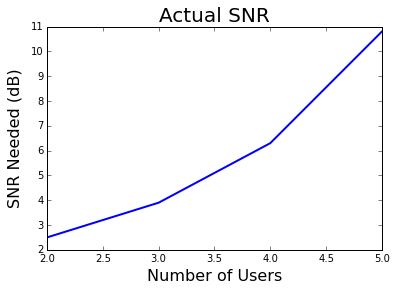

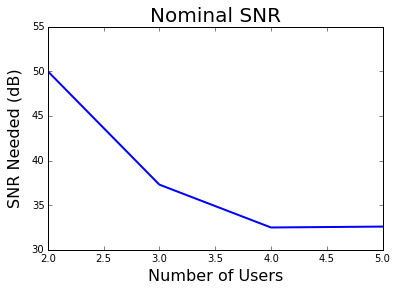

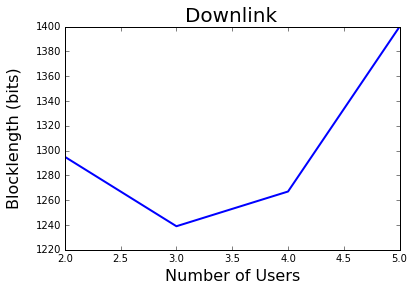

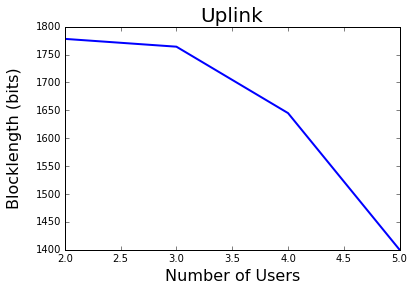

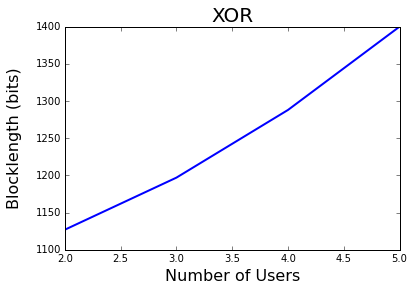

In [44]:
plot(range(2, 6), data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

In [61]:
optimize_target = []

1e-10  :  [  nan  50.4  38.4  33.2  32.8]
1e-09  :  [  nan  50.4  37.4  33.2  32.8]
1e-08  :  [  nan  50.4  37.4  32.4  32.8]
1e-07  :  [  nan  50.5  37.4  32.2  32.8]
1e-06  :  [  nan  50.3  37.4  32.2  32.8]
1e-05  :  [  nan  53.4  37.5  31.2  32.8]
0.0001  :  [  nan   nan  37.2  31.3  32.9]
CPU times: user 18min 21s, sys: 6.83 s, total: 18min 28s
Wall time: 22min 50s


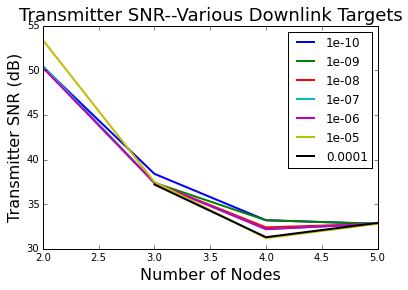

In [165]:
%%time
protocol_target = 10**(-9)
n_range = range(1, 6)
# lower precision of SNR_range leads to safe overestimate
SNR_range = arange(30, -10*log10(protocol_target), 0.1)
for linktarget in [10**i for i in range(-10, -3)]:
    data = zeros((5, 5))
    for n in n_range:
        z = optimization(n, SNR_range, filepath_down, filepath_up, linktarget, linktarget)
        data[n-1] = z
    
    print linktarget, " : ", data[:, 1]
    optimize_target.append(data[:,1])
    plot(n_range, data[:, 1], lw=2.0, label=linktarget)
    
legend(loc=0)
title('Transmitter SNR--Various Downlink Targets', fontsize=18)
xlabel('Number of Nodes', fontsize=16)
ylabel('Transmitter SNR (dB)', fontsize=16)

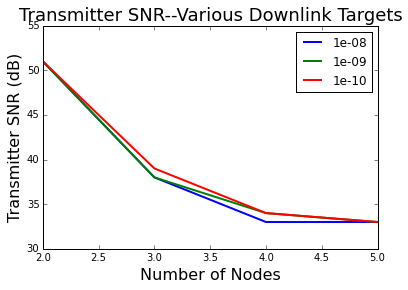

In [65]:
x = arange(1, 6)
plot(x, optimize_target[0], lw=2.0, label=10**(-8))
plot(x, optimize_target[1], lw=2.0, label=10**(-9))
plot(x, optimize_target[2], lw=2.0, label=10**(-10))
legend(loc=0)
title('Transmitter SNR--Various Downlink Targets', fontsize=18)
xlabel('Number of Nodes', fontsize=16)
ylabel('Transmitter SNR (dB)', fontsize=16)

# Not Optimized

In [151]:
# 1,400 * 3 phases = 4,200
def not_optimized(N, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up, downtarget=10**(-9), uptarget=10**(-9)):
    #downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
    protocol_target = 10**(-9)
#     downtarget, uptarget = 1 * 10**(-9), 1 * 10**(-9)
    
    downbit, upbit = 1400, 1400
    downTable = hs_rs_table(rx_SNR_range, N*160/downbit, int(downbit/21))
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    upTable = hs_rs_table(rx_SNR_range, N*160/upbit, int(upbit/21/N))
    upfunc = interp1d(upTable[0], upTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    # Replace magic number below
    xorbit = 1400
#     blocklength = int(xorbit / 21)
#     rate = N * 160 / xorbit * 7 / 4
#     k = (1-rate)*blocklength
    xor_table = hs_rs_table(rx_SNR_range, N*160/xorbit, int(xorbit/21))
    xor_func = interp1d(xor_table[0], xor_table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    for nominal_SNR in tx_SNR_range:
        for actual_SNR in arange(max(0, nominal_SNR-90), nominal_SNR, 1):
            if downfunc(actual_SNR) > downtarget: continue
            if upfunc(actual_SNR) > uptarget: continue

#             pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
#             hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
#             hcf = 1 - (1-hcerr)**3
#             reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
            p_add_3 = xor_func(actual_SNR)
            xor_opt = xor_analysis_opt(N, p_add_3, nominal_SNR, actual_SNR, downfunc(actual_SNR), upfunc(actual_SNR))
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nominal_SNR, downbit, upbit, xorbit)

In [152]:
%%time
protocol_target = 10**(-9)
rx_SNR_range = arange(-2.5, 11, 0.01)
tx_SNR_range = arange(30, -10*log10(protocol_target), 0.1)
not_opt_data = zeros((5, 5))
for n in range(1, 6):
    z = not_optimized(n, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up, 10**(-9), 10**(-9))
    not_opt_data[n-1] = z

# print data

CPU times: user 15.8 s, sys: 192 ms, total: 16 s
Wall time: 19.8 s


In [153]:
print not_opt_data

[[    nan     nan     nan     nan     nan]
 [    4.     51.4  1400.   1400.   1400. ]
 [    6.     39.4  1400.   1400.   1400. ]
 [    8.     34.2  1400.   1400.   1400. ]
 [   11.     32.8  1400.   1400.   1400. ]]


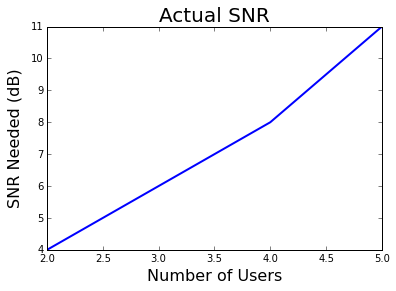

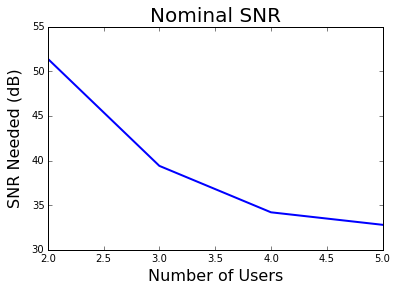

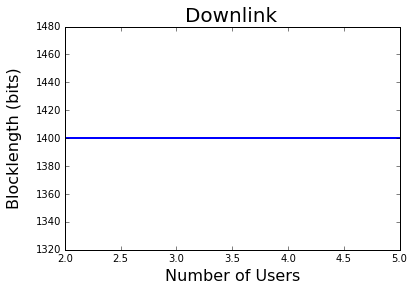

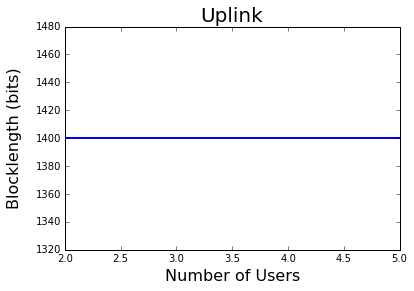

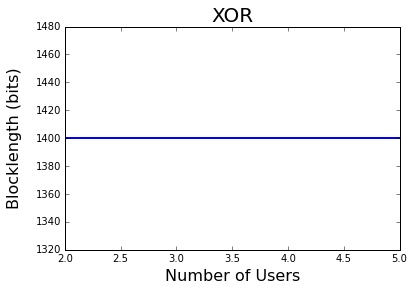

In [154]:
plot(range(2, 6), not_opt_data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

# Medium Optimized

In [13]:
# 1,400 * 3 phases = 4,200
def medium_optimized(N, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up):
    #downtarget, uptarget = logsearch(10**(-8), 10**(-10), 20)
    protocol_target = 10**(-9)
#     downtarget, uptarget = 1 * 10**(-9), 1 * 10**(-9)
    
    downbit, upbit = 1400, 1400
    downTable = hs_rs_table(rx_SNR_range, N*160/downbit, int(downbit/21))
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    upTable = hs_rs_table(rx_SNR_range, N*160/upbit, int(upbit/21/N))
    upfunc = interp1d(upTable[0], upTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    xorbit = 1400
#     blocklength = int(xorbit / 21)
#     rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
#     k = (1-rate)*blocklength
    xor_table = hs_rs_table(rx_SNR_range, N*160/xorbit, int(xorbit/21))
    xor_func = interp1d(xor_table[0], xor_table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    for nominal_SNR in tx_SNR_range:
        for actual_SNR in arange(0, nominal_SNR, 1):
            p_add_3 = xor_func(actual_SNR)
            xor_opt = xor_analysis_opt(N, p_add_3, nominal_SNR, actual_SNR, downfunc(actual_SNR), upfunc(actual_SNR))
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nominal_SNR, downbit, upbit, xorbit)
            

In [138]:
N = 2
test = xor_analysis_opt(N, 0, 77.4, 8, 0, 0)
print test
print 1 - test
print (1 - test) <= 10**(-9)
medium_optimized(N, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up)

1.0
3.95239396767e-14
True
77.3 11.0 1.0
0.0 1.0 1.0
77.3 12.0 1.0
0.0 1.0 1.0
77.3 13.0 1.0
0.0 1.0 1.0
77.3 14.0 1.0
0.0 1.0 1.0
77.3 15.0 1.0
0.0 1.0 1.0
77.3 16.0 1.0
0.0 1.0 1.0
77.3 17.0 1.0
0.0 1.0 1.0
77.3 18.0 1.0
0.0 1.0 1.0
77.3 19.0 1.0
0.0 1.0 1.0
77.3 20.0 1.0
0.0 1.0 1.0
77.3 21.0 1.0
0.0 1.0 1.0
77.3 22.0 1.0
0.0 1.0 1.0
77.3 23.0 1.0
0.0 1.0 1.0
77.3 24.0 1.0
0.0 1.0 1.0
77.3 25.0 1.0
0.0 1.0 1.0
77.3 26.0 1.0
0.0 1.0 1.0
77.3 27.0 1.0
0.0 1.0 1.0
77.3 28.0 1.0
0.0 1.0 1.0
77.3 29.0 1.0
0.0 1.0 1.0
77.3 30.0 1.04017827685e-09
0.0 0.0 0.0
77.3 31.0 1.64855817886e-09
0.0 0.0 0.0
77.3 32.0 2.61276222879e-09
0.0 0.0 0.0
77.3 33.0 4.14089640355e-09
0.0 0.0 0.0
77.3 34.0 6.56277332478e-09
0.0 0.0 0.0
77.3 35.0 1.04010846602e-08
0.0 0.0 0.0
77.3 36.0 1.64841894579e-08
0.0 0.0 0.0
77.3 37.0 2.61248439548e-08
0.0 0.0 0.0
77.3 38.0 4.14034198037e-08
0.0 0.0 0.0
77.3 39.0 6.56166713187e-08
0.0 0.0 0.0
77.3 40.0 1.03988778144e-07
0.0 0.0 0.0
77.3 41.0 1.64797864022e-07
0.0 0.0 0.0

(30.0, 77.400000000000674, 1400, 1400, 1400)

In [130]:
xorbit = 1400
N = 2
rx_SNR_range = arange(2, 11, 0.1)
xor_table = hs_rs_table(rx_SNR_range, N*160/xorbit, int(xorbit/21))
xor_func = interp1d(xor_table[0], xor_table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
print xor_func(10)

1.2995047841e-164


In [17]:
%%time
protocol_target = 10**(-9)
rx_SNR_range = arange(2, 11, 0.1)
tx_SNR_range = arange(30, -10*log10(protocol_target), 0.1)
medium_data = zeros((5, 5))
for n in range(1, 6):
    z = medium_optimized(n, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up)
    medium_data[n-1] = z

# print data

CPU times: user 4.08 s, sys: 33.9 ms, total: 4.12 s
Wall time: 4.12 s


In [18]:
print medium_data

[[    nan     nan     nan     nan     nan]
 [    3.     50.4  1400.   1400.   1400. ]
 [    4.     37.4  1400.   1400.   1400. ]
 [    5.     31.7  1400.   1400.   1400. ]
 [   11.     32.8  1400.   1400.   1400. ]]


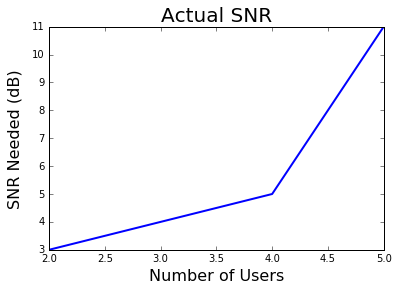

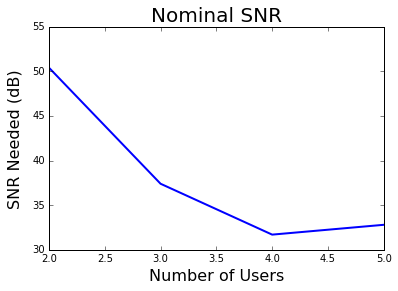

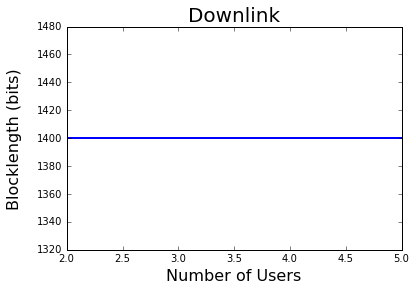

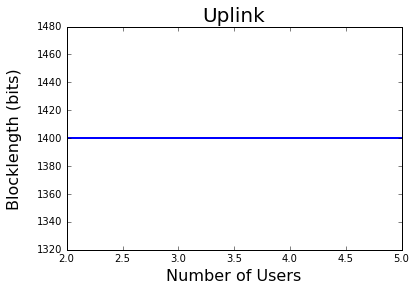

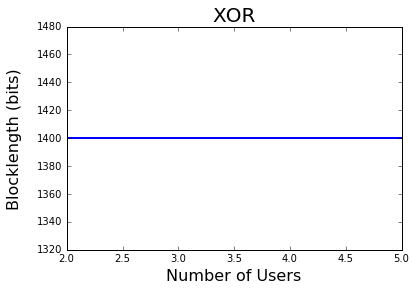

In [19]:
plot(range(2, 6), medium_data[1:5, 0], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 1], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), medium_data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

# More Optimized

In [54]:
def optimization(N, tx_SNR_range, filepath_down, filepath_up, downtarget=10**(-9), uptarget=10**(-9)):
    protocol_target = 10**(-9)
    downFile = filepath_down + str(N) + '.in'
    downNode = load_table(downFile)
    upFile = filepath_up + str(N) + '.in'
    upNode = load_table(upFile)
    
    for nominal_SNR in tx_SNR_range:
        for actual_SNR in arange(max(0, nominal_SNR-90), nominal_SNR, 0.1):
            downbit, upbit = float("inf"), float("inf")
            for bit in downNode.bitrange:
                bittable = downNode.tables[bit]
                func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
                if func(actual_SNR) <= downtarget:
                    downbit = bit
                    break
            for bit in upNode.bitrange:
                bittable = upNode.tables[bit]
                func = interp1d(bittable[0], bittable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
                if func(actual_SNR) <= uptarget:
                    upbit = bit
                    break
            xorbit = 4200 - downbit - upbit
            if xorbit <= 0: continue
#             xorbit = max(0, 4200 - downbit - upbit)
            # We calculate reeddrop each time because the rate changes every time (new table)
            blocklength = int(xorbit / 21)
            rate = N * 160 / xorbit * 7 / 4 if xorbit else float("inf")
            if rate > 1: continue
            k = (1-rate)*blocklength
            pbitdrop = Q(np.sqrt(2*10**(actual_SNR/10)))
            hcerr = 1 - ((1-pbitdrop)**7 + 7*pbitdrop*(1-pbitdrop)**6)
            hcf = 1 - (1-hcerr)**3
            reeddrop = sum([nCr(blocklength, d)* hcf**d *(1-hcf)**(blocklength-d) for d in range(int(k/2)+1, blocklength)])
            xor_opt = xor_analysis_opt(N, reeddrop, nominal_SNR, actual_SNR, downtarget, uptarget)
            if 1-xor_opt <= protocol_target:
                return (actual_SNR, nominal_SNR, downbit, upbit, xorbit)
#             if actual_SNR == SNR_range[-1]:
#                 print N, actual_SNR, downbit, upbit, xorbit, reeddrop
#     print N, nominal_SNR, actual_SNR, downbit, upbit, xorbit, reeddrop
#     return (10, 10, 10, 10, 10) # fake data to show answer outside nominal range

In [65]:
linktarget = [10**i for i in range(-10, -3)]
test = array([1, 2, 3])
test2 = concatenate((test, array([5])))
print test
print test2

[1 2 3]
[1 2 3 5]


In [68]:
def more_optimized(N, tx_SNR_range, filepath_down, filepath_up):
    linktarget = [10**i for i in range(-10, -3)]
    optimize_target = zeros((7, 6))
    for idx in range(7):
        optimize_target[idx] = concatenate((optimization(N, tx_SNR_range, filepath_down, filepath_up, linktarget[idx], linktarget[idx]), array([linktarget[idx]])))
        print optimize_target[idx]
    return optimize_target[np.argmin(optimize_target[:,1])]

In [69]:
%%time
N = 5
protocol_target = 10**(-9)
rx_SNR_range = arange(0, 12, 0.01)
tx_SNR_range = arange(30, -10*log10(protocol_target), 0.01)
test = more_optimized(N, tx_SNR_range, filepath_down, filepath_up)
print "test", test

[  1.10000000e+01   3.27500000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-10]
[  1.08000000e+01   3.25900000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-09]
[  1.06000000e+01   3.25100000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-08]
[  1.06000000e+01   3.25100000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-07]
[  1.06000000e+01   3.25100000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-06]
[  1.06000000e+01   3.25200000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-05]
[  1.06000000e+01   3.25700000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-04]
test [  1.06000000e+01   3.25100000e+01   1.40000000e+03   1.40000000e+03
   1.40000000e+03   1.00000000e-08]
CPU times: user 16min 23s, sys: 3.51 s, total: 16min 26s
Wall time: 30min 37s


In [50]:
print test[np.argmax(test[:,1])]

TypeError: 'NoneType' object has no attribute '__getitem__'

In [ ]:
%%time
protocol_target = 10**(-9)
n_range = range(1, 6)
# lower precision of SNR_range leads to safe overestimate
SNR_range = arange(30, -10*log10(protocol_target), 0.1)
for linktarget in [10**i for i in range(-10, -3)]:
    data = zeros((5, 5))
    for n in n_range:
        z = optimization(n, SNR_range, filepath_down, filepath_up, linktarget, linktarget)
        data[n-1] = z
    
    print linktarget, " : ", data[:, 1]
    optimize_target.append(data[:,1])
    plot(n_range, data[:, 1], lw=2.0, label=linktarget)
    
legend(loc=0)
title('Transmitter SNR--Various Downlink Targets', fontsize=18)
xlabel('Number of Nodes', fontsize=16)
ylabel('Transmitter SNR (dB)', fontsize=16)

## Really Not Optimized

In [9]:
filepath_down = filepath_up = "tmp_dummy"

In [7]:
# 1,400 * 3 phases = 4,200
def naive_optimized(N, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up, downtarget=10**(-10), uptarget=10**(-10)):
    protocol_target = 10**(-9)
    p_add_3 = 10**(-10)
    
    downbit, upbit = 1400, 1400
    downTable = hs_rs_table(rx_SNR_range, N*160/downbit, int(downbit/21))
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    upTable = hs_rs_table(rx_SNR_range, N*160/upbit, int(upbit/21/N))
    upfunc = interp1d(upTable[0], upTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    # Replace magic number below
    xorbit = 1400
    xor_table = hs_rs_table(rx_SNR_range, N*160/xorbit, int(xorbit/21))
    xor_func = interp1d(xor_table[0], xor_table[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))
    
    down_SNR = downTable[0][np.where(downTable[1]<=downtarget)[0][0]]
    up_SNR = upTable[0][np.where(upTable[1]<=uptarget)[0][0]]
    xor_SNR = xor_table[0][np.where(xor_table[1]<=p_add_3)[0][0]]
    actual_SNR = max(down_SNR, up_SNR, xor_SNR)
    
    for nominal_SNR in tx_SNR_range:
        xor_opt = xor_analysis_opt(N, xor_func(actual_SNR), nominal_SNR, actual_SNR, downfunc(actual_SNR), upfunc(actual_SNR))
        if 1-xor_opt <= protocol_target:
            return (actual_SNR, nominal_SNR, downbit, upbit, xorbit)

In [12]:
%%time
protocol_target = 10**(-9)
rx_SNR_range = arange(0, 12, 0.01)
tx_SNR_range = arange(30, -10*log10(protocol_target), 0.01)
naive_data = zeros((5, 5))
for n in range(1, 6):
    z = naive_optimized(n, rx_SNR_range, tx_SNR_range, filepath_down, filepath_up)
    naive_data[n-1] = z

CPU times: user 4.48 s, sys: 70.7 ms, total: 4.55 s
Wall time: 4.51 s


In [13]:
print naive_data

[[     nan      nan      nan      nan      nan]
 [    3.55    50.94  1400.    1400.    1400.  ]
 [    5.31    38.65  1400.    1400.    1400.  ]
 [    8.29    34.44  1400.    1400.    1400.  ]
 [   11.18    32.92  1400.    1400.    1400.  ]]


# Penalty

In [170]:
print not_opt_data

print data

[[    nan     nan     nan     nan     nan]
 [    4.     51.4  1400.   1400.   1400. ]
 [    6.     39.4  1400.   1400.   1400. ]
 [    8.     34.2  1400.   1400.   1400. ]
 [   11.     32.8  1400.   1400.   1400. ]]
[[    nan     nan     nan     nan     nan]
 [    2.5    50.   1295.   1778.   1127. ]
 [    3.9    37.3  1239.   1764.   1197. ]
 [    6.3    32.5  1267.   1645.   1288. ]
 [   10.8    32.6  1400.   1400.   1400. ]]


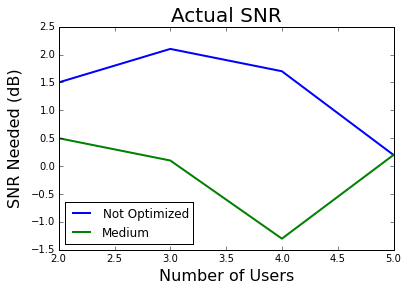

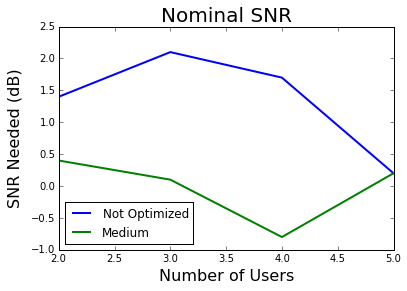

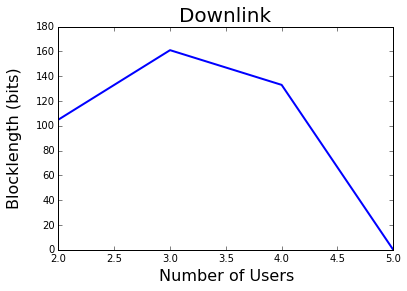

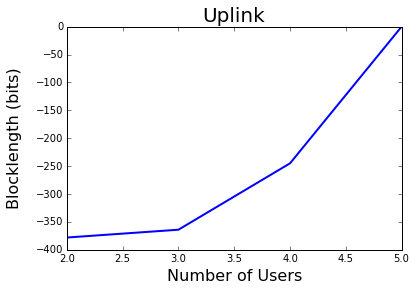

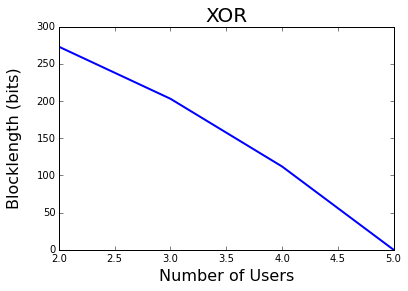

In [169]:
plot(range(2, 6), not_opt_data[1:5, 0]-data[1:5, 0], lw=2.0, label='Not Optimized')
plot(range(2, 6), medium_data[1:5, 0]-data[1:5, 0], lw=2.0, label='Medium')
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Actual SNR', fontsize=20)
legend(loc=0)

figure()
plot(range(2, 6), not_opt_data[1:5, 1]-data[1:5, 1], lw=2.0, label='Not Optimized')
plot(range(2, 6), medium_data[1:5, 1]-data[1:5, 1], lw=2.0, label='Medium')
xlabel('Number of Users', fontsize=16)
ylabel('SNR Needed (dB)', fontsize=16, labelpad=10)
title('Nominal SNR', fontsize=20)
legend(loc=0)

figure()
plot(range(2, 6), not_opt_data[1:5, 2]-data[1:5, 2], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Downlink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 3]-data[1:5, 3], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('Uplink', fontsize=20)

figure()
plot(range(2, 6), not_opt_data[1:5, 4]-data[1:5, 4], lw=2.0)
xlabel('Number of Users', fontsize=16)
ylabel('Blocklength (bits)', fontsize=16, labelpad=15)
title('XOR', fontsize=20)

In [156]:
print not_opt_data[1:5, 1]-data[1:5, 1]

print medium_data[1:5, 1]-data[1:5, 1]

[ 1.4  2.1  1.7  0.2]
[ 0.4  0.1 -0.8  0.2]


In [77]:
print not_opt_data[1:5, 1]-medium_data[1:5, 1]

[-10.12  -3.97  -1.69 -22.99]


In [167]:
data = array([[    nan ,    nan  ,   nan  ,   nan   ,  nan],
 [    2.5  ,  50.  , 1295.  , 1778.  , 1127. ],
 [    3.9 ,   37.3 , 1239.  , 1764.  , 1197. ],
 [    6.3  ,  32.5 , 1267. ,  1645. ,  1288. ],
 [   10.8  ,  32.6 , 1400.  , 1400. ,  1400. ]])

In [168]:
print data

[[    nan     nan     nan     nan     nan]
 [    2.5    50.   1295.   1778.   1127. ]
 [    3.9    37.3  1239.   1764.   1197. ]
 [    6.3    32.5  1267.   1645.   1288. ]
 [   10.8    32.6  1400.   1400.   1400. ]]


## Generating Toy Tables for Shannon

In [89]:
# Does this make sense for Shannon?

# 21 is arbitrary quantization taken from Hamming quantization
# 1400 = min bits for one phase, 4200 = entire protocol
# shannon_table(rate)
class node_table_shannon():
    op_SNR = arange(-16, -3, 0.01)

    def __init__(self, n):
        self.num_node = n
        minb = n * 160 * 7 / 4
        bitrange = arange(minb, 3*1400-minb, 21)
        self.bitrange = bitrange
#         num_tables = len(bitrange)
        self.tables = {}
        for b in self.bitrange:
            self.tables[b] = shannon_table(n*160/b, self.op_SNR)

In [94]:
%%time
for num_nodes in arange(1,0, -1):
    node = node_table_shannon(num_nodes)
    

CPU times: user 336 ms, sys: 11.8 ms, total: 347 ms
Wall time: 339 ms


[  280.   301.   322.   343.   364.   385.   406.   427.   448.   469.
   490.   511.   532.   553.   574.   595.   616.   637.   658.   679.
   700.   721.   742.   763.   784.   805.   826.   847.   868.   889.
   910.   931.   952.   973.   994.  1015.  1036.  1057.  1078.  1099.
  1120.  1141.  1162.  1183.  1204.  1225.  1246.  1267.  1288.  1309.
  1330.  1351.  1372.  1393.  1414.  1435.  1456.  1477.  1498.  1519.
  1540.  1561.  1582.  1603.  1624.  1645.  1666.  1687.  1708.  1729.
  1750.  1771.  1792.  1813.  1834.  1855.  1876.  1897.  1918.  1939.
  1960.  1981.  2002.  2023.  2044.  2065.  2086.  2107.  2128.  2149.
  2170.  2191.  2212.  2233.  2254.  2275.  2296.  2317.  2338.  2359.
  2380.  2401.  2422.  2443.  2464.  2485.  2506.  2527.  2548.  2569.
  2590.  2611.  2632.  2653.  2674.  2695.  2716.  2737.  2758.  2779.
  2800.  2821.  2842.  2863.  2884.  2905.  2926.  2947.  2968.  2989.
  3010.  3031.  3052.  3073.  3094.  3115.  3136.  3157.  3178.  3199.
  3220

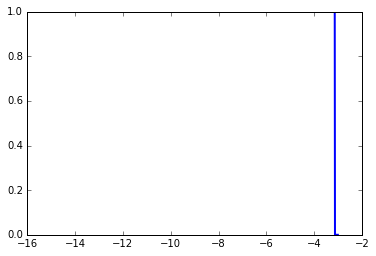

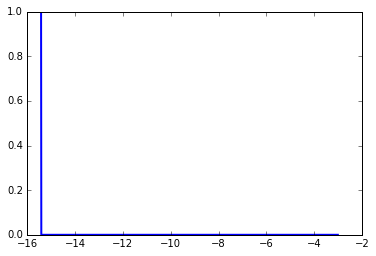

In [95]:
print node.bitrange
plot(node.tables[280][0], node.tables[280][1], lw=2.0)

figure()
plot(node.tables[3913][0], node.tables[3913][1], lw=2.0)

In [98]:
filepath_down = '../data_tables/short_block_test/shannon/n'

In [99]:
%%time
for num_nodes in arange(5, 0, -1):
    node = node_table_shannon(num_nodes)
    filename = filepath_down + str(num_nodes) + '.in'
    save_table(node, filename)

CPU times: user 1.78 s, sys: 84 ms, total: 1.86 s
Wall time: 1.84 s
